In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
import seaborn as sns

/Users/sawale/Documents/FunnyProject/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# df = pd.read_parquet("/Users/sawale/Documents/FunnyProject/data/labeled_jokes.parquet")

df = pd.read_parquet("/Users/sawale/Documents/FunnyProject/data/labeled_jokes_classification_mistral:latest.parquet")
df.shape

(571, 6)

In [4]:
df.head()

,date,joke,score,humor,offensiveness,sentiment
458171,2019-01-22 05:23:03,What is the difference between Necrophilia and...,2.0,0,1,0
454816,2019-01-12 02:49:58,Are you on the Mediterranean Diet? Because I s...,10.0,1,0,1
146573,2016-01-28 16:51:04,Few people know the FBI tried to warn George W...,0.0,1,2,0
157537,2016-03-19 21:38:43,A man dies in a hospital.... A man dies in a h...,6.0,0,1,1
458333,2019-01-22 18:44:13,"For centuries, scientists said “Drake and Josh...",9.0,1,0,1


# EDA on joke length

Token indices sequence length is longer than the specified maximum sequence length for this model (547 > 512). Running this sequence through the model will result in indexing errors


Five-Point Summary for Joke Token Counts:
min: 4
Q1: 17.0
median: 24.0
Q3: 43.0
max: 547
Percentage of documents with token counts > 512: 0.18%
Token count at 99.9th percentile: 490.00000000000637


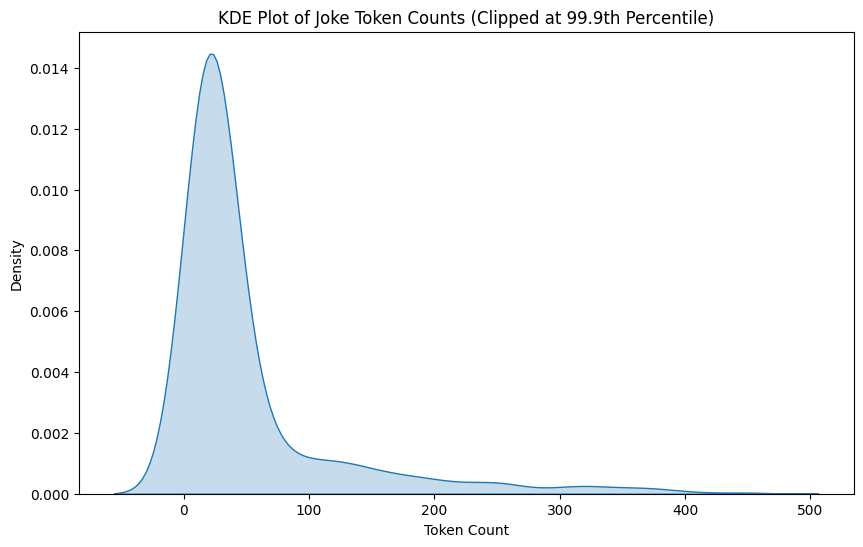

In [5]:
# Step 1: Initialize the tokenizer from Hugging Face.
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilroberta-base")

# Step 2: Create a new column to count the tokens in each joke.
# Here, tokenizer.tokenize(x) returns a list of tokens, and we take its length.
df['joke_token_count'] = df['joke'].apply(lambda x: len(tokenizer.tokenize(x)))

# Step 3: Compute the five-number summary for token counts.
five_point_summary = {
    'min': df['joke_token_count'].min(),
    'Q1': df['joke_token_count'].quantile(0.25),
    'median': df['joke_token_count'].median(),
    'Q3': df['joke_token_count'].quantile(0.75),
    'max': df['joke_token_count'].max()
}

print("Five-Point Summary for Joke Token Counts:")
for key, value in five_point_summary.items():
    print(f"{key}: {value}")

# Step 4: Calculate the percentage of documents with token count greater than 512.
docs_over_512 = (df['joke_token_count'] > 512).sum()
total_docs = len(df)
percentage_over_512 = (docs_over_512 / total_docs) * 100
print(f"Percentage of documents with token counts > 512: {percentage_over_512:.2f}%")

# Step 5: Determine the clip value: the 99.9th percentile of the token counts.
clip_value = df['joke_token_count'].quantile(0.999)
print(f"Token count at 99.9th percentile: {clip_value}")

# Step 6: Plot the KDE (Kernel Density Estimate) of the token count distribution.
# We filter the data to include only those documents with token counts less than or equal to clip_value.
plt.figure(figsize=(10, 6))
filtered_data = df[df['joke_token_count'] <= clip_value]
sns.kdeplot(data=filtered_data, x='joke_token_count', fill=True)
plt.title("KDE Plot of Joke Token Counts (Clipped at 99.9th Percentile)")
plt.xlabel("Token Count")
plt.ylabel("Density")
plt.show()

# Analysis on target columns

Distribution for humor:
       Count  Percentage (%)
humor                       
0        112           19.61
1        459           80.39


Distribution for offensiveness:
               Count  Percentage (%)
offensiveness                       
0                447           78.28
1                 92           16.11
2                 32            5.60


Distribution for sentiment:
           Count  Percentage (%)
sentiment                       
0            104           18.21
1            466           81.61
3              1            0.18




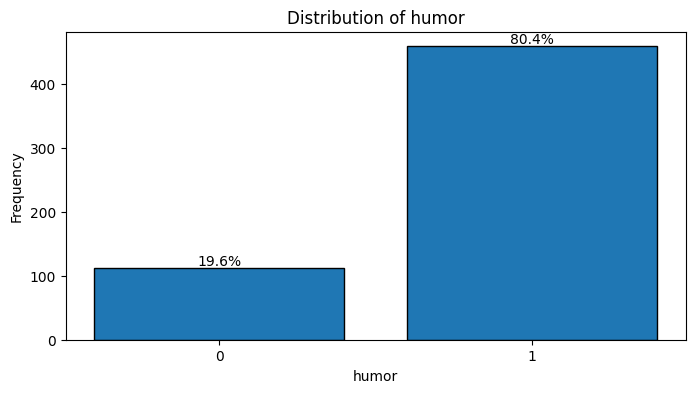

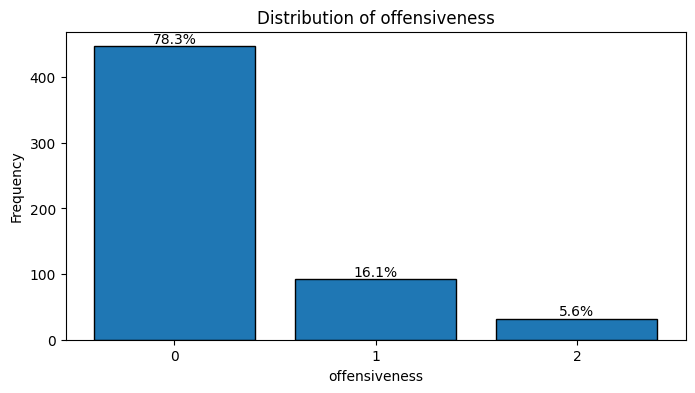

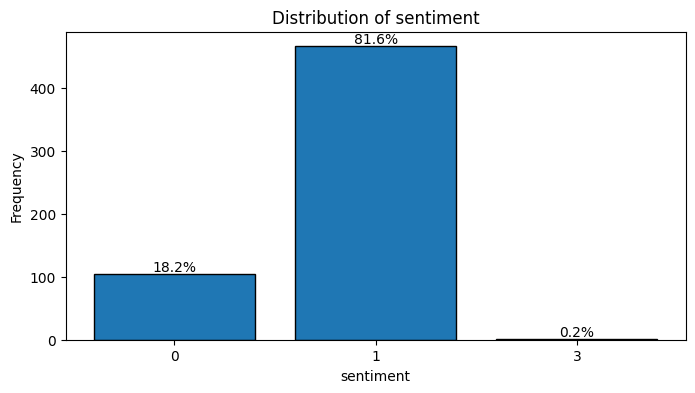

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is already loaded as 'df'
discrete_cols = ['humor', 'offensiveness', 'sentiment']

# 1. For each discrete column, print frequency counts and percentages.
for col in discrete_cols:
    print(f"Distribution for {col}:")
    counts = df[col].value_counts().sort_index()
    percentages = (counts / counts.sum() * 100).round(2)
    summary_df = pd.DataFrame({'Count': counts, 'Percentage (%)': percentages})
    print(summary_df)
    print("\n")

# 2. Plot the distribution for each discrete column using bar charts.
for col in discrete_cols:
    counts = df[col].value_counts().sort_index()
    plt.figure(figsize=(8, 4))
    plt.bar(counts.index.astype(str), counts.values, edgecolor='black')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    # Optionally, add the percentage on top of each bar for clarity.
    for index, value in counts.items():
        plt.text(x=str(index), y=value, s=f"{(value / counts.sum() * 100):.1f}%", ha='center', va='bottom')
    plt.show()


# Chroma Analysis

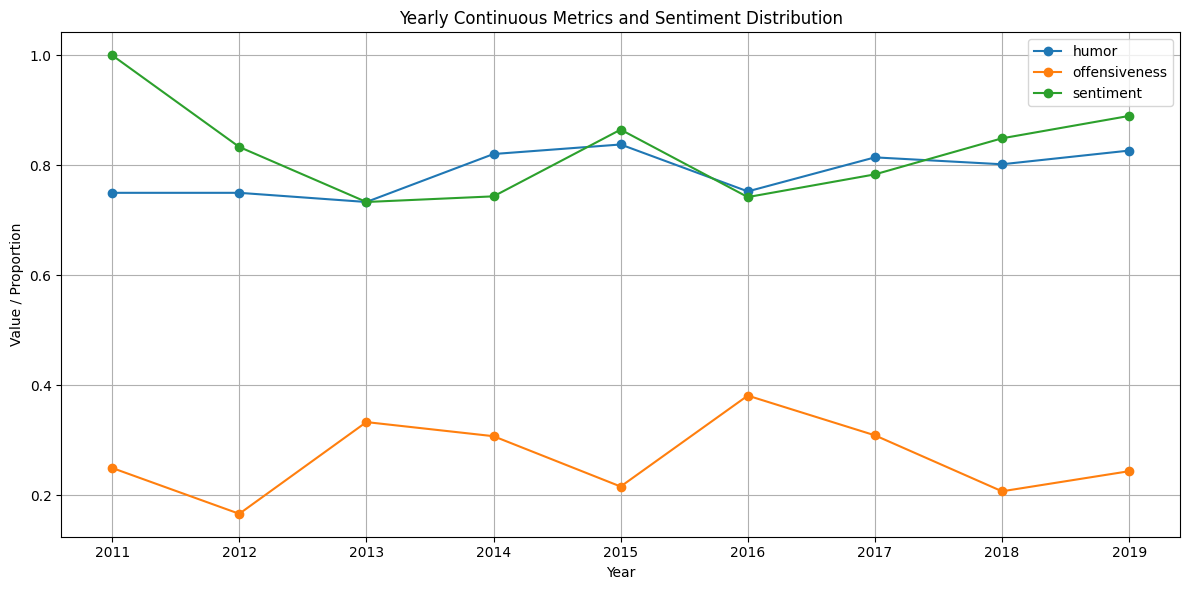

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure that the 'date' column is in datetime format and extract the year
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

# ----- 1. Continuous Metrics: Humor and Offensiveness -----
continuous_cols = ['humor', 'offensiveness', 'sentiment']
yearly_avg = df.groupby('year')[continuous_cols].mean()

# ----- Combined Plot on a Single y-axis -----
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the continuous metrics
for metric in continuous_cols:
    ax.plot(yearly_avg.index, yearly_avg[metric], marker='o', label=metric)

ax.set_xlabel('Year')
ax.set_ylabel('Value / Proportion')
ax.set_title('Yearly Continuous Metrics and Sentiment Distribution')
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()


# world cloud visulization

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

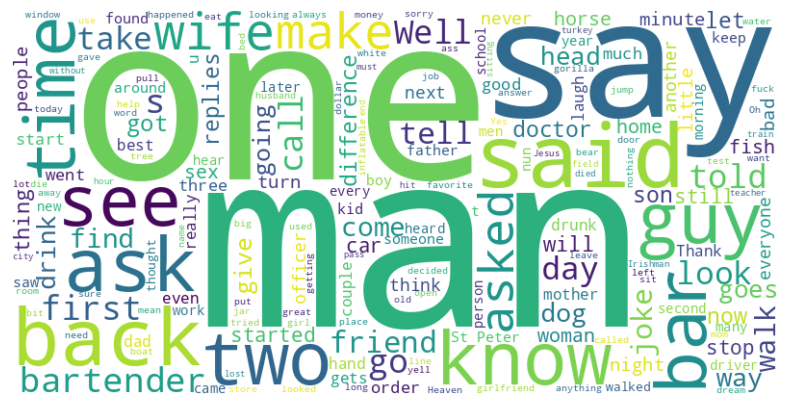

In [9]:
# word cloud for funny jokes
funny_jokes = " ".join(df[df["humor"] == 1]["joke"].to_list())
# Generate a word cloud object
wc = WordCloud(width=800, height=400, background_color='white').generate(funny_jokes)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

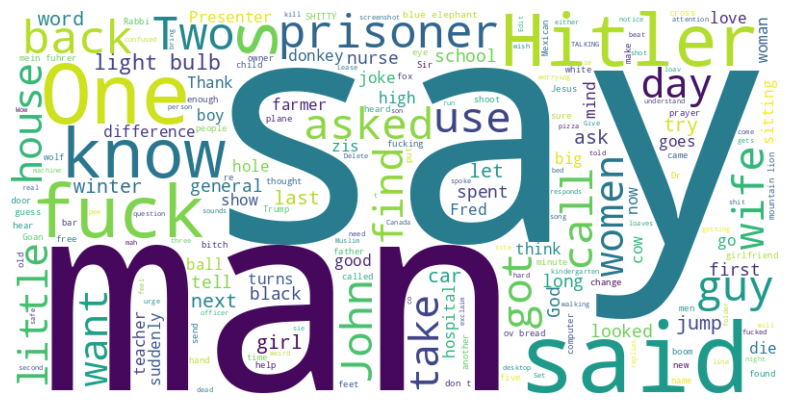

In [10]:
# word cloud for offensive jokes
off_jokes = " ".join(df[df["offensiveness"] == 1]["joke"].to_list())
# Generate a word cloud object
wc = WordCloud(width=800, height=400, background_color='white').generate(off_jokes)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

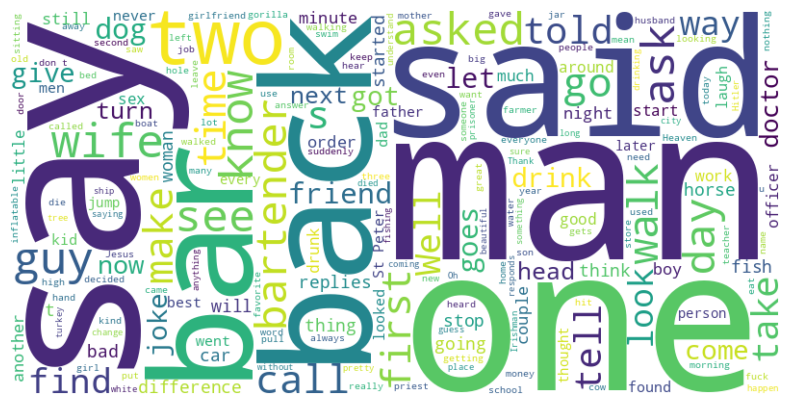

In [11]:
# word cloud for positive jokes
pos_jokes = " ".join(df[df["sentiment"] == 1]["joke"].to_list())
# Generate a word cloud object
wc = WordCloud(width=800, height=400, background_color='white').generate(pos_jokes)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

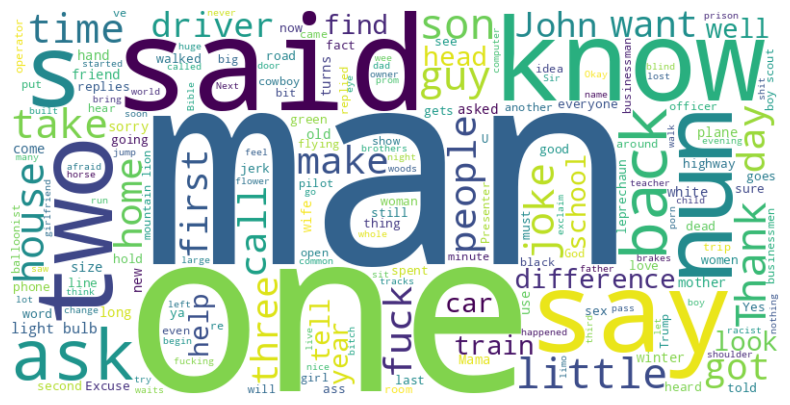

In [12]:
# word cloud for positive jokes
neg_jokes = " ".join(df[df["sentiment"] == 0]["joke"].to_list())
# Generate a word cloud object
wc = WordCloud(width=800, height=400, background_color='white').generate(neg_jokes)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [17]:
# checking samples
df[df["humor"] == 1]["joke"].iloc[6]

"I can't find my Liszt of composer puns If any of you can get a Holst of it, could you Handel it to me?"

In [14]:
df[(df["offensiveness"] == 1) & (df["humor"] == 1)]["joke"].iloc[3]

IndexError: single positional indexer is out-of-bounds